In [8]:
!pip install -q joblib

In [9]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
csv_filename = "/content/drive/MyDrive/MIC Recruitment 2025/IMDB Dataset.csv"
print("Using:", csv_filename)


Mounted at /content/drive
Using: /content/drive/MyDrive/MIC Recruitment 2025/IMDB Dataset.csv


In [11]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import os

RANDOM_STATE = 42

def preprocess_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [12]:
df = pd.read_csv(csv_filename)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(3))

print("\nMissing values per column:\n", df.isnull().sum())
if 'review' not in df.columns or 'sentiment' not in df.columns:
    print("\nWARNING: Expected columns 'review' and 'sentiment'. If your headers differs, change them now.")

print("\nLabel distribution:")
display(df['sentiment'].value_counts())


Shape: (50000, 2)
Columns: ['review', 'sentiment']


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive



Missing values per column:
 review       0
sentiment    0
dtype: int64

Label distribution:


,count
sentiment,
positive,25000
negative,25000


In [13]:

df = df.dropna(subset=['review', 'sentiment']).copy()

df['clean_review'] = df['review'].apply(preprocess_text)

display(df[['review','clean_review']].head(6))
print("\nExample cleaned text length statistics:")
print(df['clean_review'].str.len().describe())


,review,clean_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei s love in the time of money is a...
5,"Probably my all-time favorite movie, a story o...",probably my all time favorite movie a story of...



Example cleaned text length statistics:
count    50000.000000
mean      1248.242200
std        944.441507
min         30.000000
25%        668.000000
50%        925.000000
75%       1514.000000
max      13315.000000
Name: clean_review, dtype: float64


In [14]:
unique_labels = df['sentiment'].unique()
print("Unique labels found:", unique_labels)

if set(unique_labels) <= {'positive','negative'}:
    df['label'] = df['sentiment'].map({'negative':0, 'positive':1})
elif set(unique_labels) <= {'pos','neg'}:
    df['label'] = df['sentiment'].map({'neg':0, 'pos':1})
else:
    try:
        df['label'] = df['sentiment'].astype(int)
    except Exception as e:
        raise ValueError(f"Unsupported label format: {unique_labels}") from e

print("Label distribution (numeric):")
display(df['label'].value_counts())


Unique labels found: ['positive' 'negative']
Label distribution (numeric):


,count
label,
1,25000
0,25000


In [15]:
X = df['clean_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 40000 Test size: 10000


In [31]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    stop_words='english',
    max_features=60000,
    ngram_range=(1,3),
    min_df=2,
    max_df=0.85,
    binary=False
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [32]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=7000, solver='lbfgs',C=3.0,class_weight='balanced',random_state=42,n_jobs=-1)
model.fit(X_train_vec, y_train)

print("Training completed.")


Training completed.


In [33]:

y_pred = model.predict(X_test_vec)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


Test Accuracy: 0.8949

Classification Report:
              precision    recall  f1-score   support

           0     0.8985    0.8904    0.8944      5000
           1     0.8914    0.8994    0.8954      5000

    accuracy                         0.8949     10000
   macro avg     0.8949    0.8949    0.8949     10000
weighted avg     0.8949    0.8949    0.8949     10000



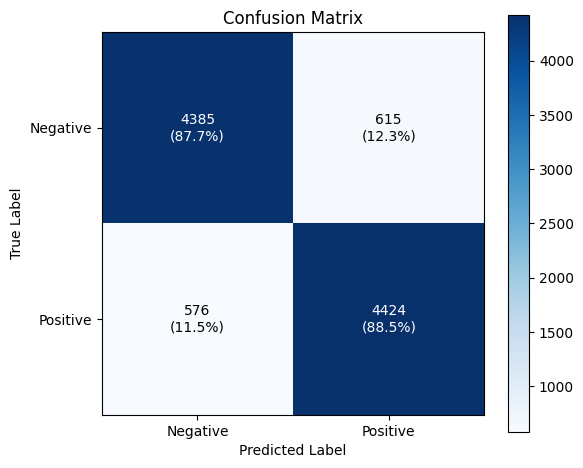

In [19]:

y_pred = model.predict(X_test_vec)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

classes = ['Negative','Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = count / cm.sum(axis=1)[i] * 100
        plt.text(j, i, f"{count}\n({pct:.1f}%)",
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [21]:
OUT_DIR = "/content/drive/MyDrive/output_models"
os.makedirs(OUT_DIR, exist_ok=True)

vec_path = os.path.join(OUT_DIR, "count_vectorizer.joblib")
model_path = os.path.join(OUT_DIR, "logreg_model_count.joblib")

joblib.dump(vectorizer, vec_path)
joblib.dump(model, model_path)

print("Saved Count vectorizer to:", vec_path)
print("Saved Logistic Regression model to:", model_path)

Saved Count vectorizer to: /content/drive/MyDrive/output_models/count_vectorizer.joblib
Saved Logistic Regression model to: /content/drive/MyDrive/output_models/logreg_model_count.joblib


In [22]:
def predict_text(review_text):
    clean = preprocess_text(review_text)
    vec = vectorizer.transform([clean])
    pred = model.predict(vec)[0]
    prob = model.predict_proba(vec).max() if hasattr(model, "predict_proba") else None
    label = "Positive" if pred == 1 else "Negative"
    return label, prob

your_review = input("Type a movie review: ")
label, prob = predict_text(your_review)
print(f"Prediction: {label} (confidence {prob})")

Type a movie review: Lovely film
Prediction: Positive (confidence 0.6759761636261118)
